In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sn
import os
import matplotlib.pyplot as plt

In [2]:
df_keys = ["n_data", "comp_time_total", 
           "time/chain_max", "time/chain_min", "time/chain_mean",
           "MC_it_min", "MC_it_max", "MC_it_mean", "MC_it_total",
           "mix_max", "mix_min", "mix_mean",
           "MC_std_err_min", "MC_std_err_max", "MC_std_err_mean",
           "eff_size_min", "eff_size_max", "eff_size_mean",
           "thinning_min", "thinning_max", "thinning_mean",
           "file_size_MB"]
file_keys = ["time",
           "MC_it",
           "components",
           "MC_std_err_min", "MC_std_err_max",
           "eff_size_min", "eff_size_max",
           "thinning_min", "thinning_max"]
    
line_prefix = ["MCMC time",
               "USED COMPONENTS",
               "rel. MC standard error",
               "eff. sample size",
               "needed thinning",
               "Total number of iterations"]

df = pd.DataFrame(columns = df_keys)

In [3]:
def process(i, line, df):
    for prefix in line_prefix:
        #print(prefix)
        #print(line)
        if prefix in line:
            #print("match", line, prefix)

            if prefix == "MCMC time":
                time = int(re.findall('\d+', line)[0])
                # parse secs, mins, hours to seconds
                if "secs" in line:
                    time = time
                elif "mins" in line:
                    time = time*60
                elif "hours":
                    time = time*60*60
                df["time"][i] = time

            if prefix == "USED COMPONENTS":  
                string = re.split(r"\:", line)[-1]
                numbers = [int(num) for num in re.findall(r'[\d]+', string)]
                components = numbers[0]
                if np.isnan(df["components"][i]):
                    df["components"][i] = components

            if prefix == "Total number of iterations":
                numbers = [int(num) for num in re.findall(r'[\d]+', line)]
                remaining = numbers[1]
                if remaining == 0:
                    its_used = numbers[0]
                    df["MC_it"][i] = its_used
                    
            if prefix == "rel. MC standard error":
                string = re.split(r"\:", line)[-1]
                numbers = [float(num) for num in re.findall(r'[\d.]+', string)]
                low_value = numbers[0]
                high_value = numbers[1]
                df["MC_std_err_min"][i] = low_value
                df["MC_std_err_max"][i] = high_value

            if prefix == "eff. sample size":
                string = re.split(r"\:", line)[-1]
                numbers = [int(num) for num in re.findall(r'[\d]+', string)]
                low_value = numbers[0]
                high_value = numbers[1]
                df["eff_size_min"][i] = low_value
                df["eff_size_max"][i] = high_value

            if prefix == "needed thinning":
                string = re.split(r"\:", line)[-1]
                numbers = [int(num) for num in re.findall(r'[\d]+', string)]
                low_value = numbers[0]
                high_value = numbers[1]
                df["thinning_min"][i] = low_value
                df["thinning_max"][i] = high_value

    return df

In [4]:
def get_df(n_data, dir_names, log_files, df_keys, file_keys):
    df = pd.DataFrame(columns = df_keys, index = range(len(dir_names)))
    for i in range(len(dir_names)):
        df_dir = pd.DataFrame(columns = file_keys, index = range(len(log_files)))
        for j in range(len(log_files)):
            filename = f"{dir_names[i]}{log_files[j]}"
            with open(filename, 'r') as file:
                while True:
                    line = file.readline()
                    if not line:
                        break
                    # Process line of data
                    df_dir = process(j, line, df_dir)

        df["n_data"][i] = n_data[i]
        df["comp_time_total"][i] = df_dir["time"].sum()
        df["time/chain_max"][i] = df_dir["time"].max()
        df["time/chain_min"][i] = df_dir["time"].min()
        df["time/chain_mean"][i] = df_dir["time"].mean()
        df["MC_it_total"][i] = df_dir["MC_it"].sum()
        df["MC_it_min"][i] = df_dir["MC_it"].min()
        df["MC_it_max"][i] = df_dir["MC_it"].max()
        df["MC_it_mean"][i] = df_dir["MC_it"].mean()
        df["mix_max"][i] = df_dir["components"].max()
        df["mix_min"][i] = df_dir["components"].min()
        df["mix_mean"][i] = df_dir["components"].mean()
        df["MC_std_err_max"][i] = df_dir["MC_std_err_max"].max()
        df["MC_std_err_min"][i] = df_dir["MC_std_err_min"].min()
        df["MC_std_err_mean"][i] = np.mean(df_dir["MC_std_err_max"] - df_dir["MC_std_err_min"])
        df["eff_size_max"][i] = df_dir["eff_size_max"].max()
        df["eff_size_min"][i] = df_dir["eff_size_min"].min()
        df["eff_size_mean"][i] = np.mean(df_dir["eff_size_max"] - df_dir["eff_size_min"])
        df["thinning_max"][i] = df_dir["thinning_max"].max()
        df["thinning_min"][i] = df_dir["thinning_min"].min()
        df["thinning_mean"][i] = np.mean(df_dir["thinning_max"] - df_dir["thinning_min"])
        # File size
        df["file_size_MB"][i] = os.path.getsize(f"{dir_names[i]}learnt.rds")/10**6
    return df

In [8]:
#n_data = [2, 4, 8, 16, 32, 64, 128, 256, 300, 500, 512, 900, 1024, 1200, 1500, 1800, 2048, 2100, 2400, 2700, 3000, 4096]
#n_data = [10, 40, 80, 120, 150, 200, 250, 300, 500, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3600]
n_data = [900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3600]
dir_names = [f"inference/train_n_5000_kr7_kg3_s1_vary_a1_False/nsamples-1200_nchains-20_ndata-{n}/" for n in n_data]
log_files = [f"log-{i}.log" for i in range(1, 21)]

df_normal = get_df(n_data, dir_names, log_files, df_keys, file_keys)
df_normal

,n_data,comp_time_total,time/chain_max,time/chain_min,time/chain_mean,MC_it_min,MC_it_max,MC_it_mean,MC_it_total,mix_max,...,MC_std_err_min,MC_std_err_max,MC_std_err_mean,eff_size_min,eff_size_max,eff_size_mean,thinning_min,thinning_max,thinning_mean,file_size_MB
0,900,23700,3180,240,1185.0,3600,39145,13853.4,277068,55,...,0.00472,0.05,0.036819,401,45000,13724.35,2,146,48.4,4.092236
1,1200,29280,7200,360,1464.0,3600,78533,14768.45,295369,57,...,0.00326,0.0499,0.03687,402,94100,15708.0,2,288,52.2,4.089366
2,1500,29400,3600,480,1470.0,3600,39995,11146.45,222929,63,...,0.00477,0.05,0.038407,400,44000,11608.6,2,148,39.4,4.086424
3,1800,34620,3600,540,1731.0,3600,33296,10975.45,219509,57,...,0.00603,0.05,0.036671,400,27500,10136.6,1,122,38.05,4.086296
4,2100,49560,7200,960,2478.0,3600,39562,15268.05,305361,63,...,0.00501,0.05,0.039512,400,39900,15612.6,1,146,54.55,4.084616
5,2400,56160,10800,720,2808.0,3600,55430,14475.7,289514,64,...,0.00405,0.0499,0.038594,402,61000,15515.75,1,205,51.7,4.082235
6,2700,54780,14400,780,2739.0,3600,68211,14337.4,286748,64,...,0.00378,0.05,0.036922,400,70100,14511.25,2,252,50.6,4.082818
7,3000,72540,14400,900,3627.0,3600,73300,17590.75,351815,67,...,0.00364,0.05,0.037026,400,75500,18487.05,1,273,62.3,4.079544
8,3300,77220,14400,1020,3861.0,3600,56303,15237.15,304743,64,...,0.00418,0.05,0.039225,400,57300,15711.75,2,211,54.5,4.079327
9,3600,121080,21600,1020,6054.0,3600,84381,22610.45,452209,66,...,0.00375,0.05,0.040549,400,71000,21973.1,1,315,82.0,4.078453


In [11]:
49560/(60*60)

13.766666666666667

Text(0.5, 1.0, '2 continous variables, 1 discrete, 5 test points')

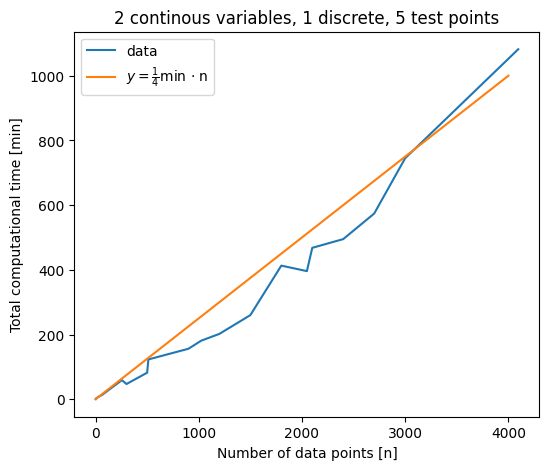

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
df_normal["comp_time_total_mins"] = df_normal["comp_time_total"]/60
sn.lineplot(data = df_normal, x = "n_data", y = "comp_time_total_mins", label="data", ax = ax)
ax.set_xlabel("Number of data points [n]")
ax.set_ylabel("Total computational time [min]")
x = np.arange(0, 2**12, 500)
#ax.plot(x, x/60, label="y=x")
ax.plot(x, 10*x/40, label=r"$y=\frac{1}{4}$min $\cdot$ n")
ax.legend()
ax.set_title("2 continous variables, 1 discrete, 5 test points")

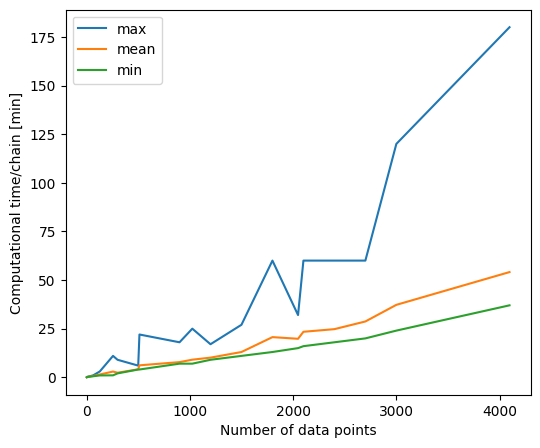

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
df_normal["time/chain_max_mins"] = df_normal["time/chain_max"]/60
df_normal["time/chain_mean_mins"] = df_normal["time/chain_mean"]/60
df_normal["time/chain_min_mins"] = df_normal["time/chain_min"]/60
sn.lineplot(data = df_normal, x = "n_data", y = "time/chain_max_mins", label="max", ax = ax)
sn.lineplot(data = df_normal, x = "n_data", y = "time/chain_mean_mins", label="mean", ax = ax)
sn.lineplot(data = df_normal, x = "n_data", y = "time/chain_min_mins", label="min", ax = ax)
ax.set_xlabel("Number of data points")
ax.set_ylabel("Computational time/chain [min]")
x = np.linspace(0, 2**12, 500)
#ax.plot(x, (3/4)*(1/20)*x, label=r"$y=\frac{3}{80}$x")
ax.legend()

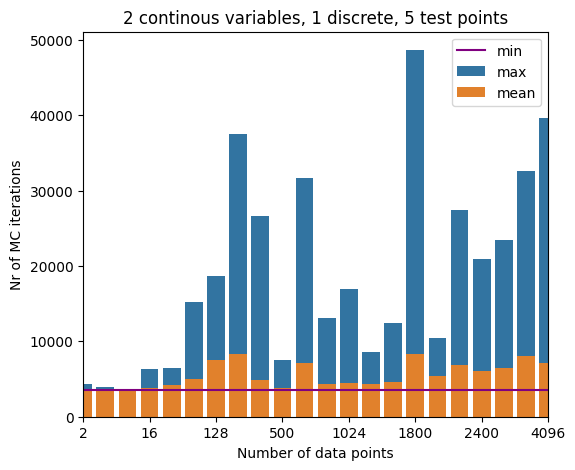

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
sn.barplot(data = df_normal, x = "n_data", y = "MC_it_max", label="max", ax = ax)
sn.barplot(data = df_normal, x = "n_data", y = "MC_it_mean", label="mean", ax = ax)
ax.set_xlabel("Number of data points")
ax.set_ylabel("Nr of MC iterations")
x = np.linspace(0, 30, 500)
ax.plot(x, x*0 + 3600, label="min", color="purple")
#ax.plot(x, 10*x, label="y=10x")
ax.set_xlim(0, 10)
ax.set_xticks([3*i for i in range(8)])
ax.set_title("2 continous variables, 1 discrete, 5 test points")
ax.legend()

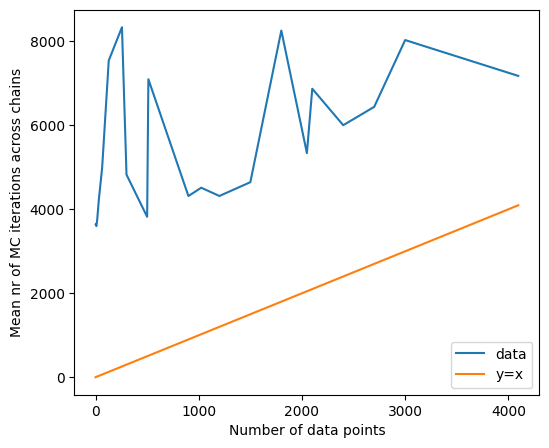

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
sn.lineplot(data = df_normal, x = "n_data", y = "MC_it_mean", label="data", ax = ax)
ax.set_xlabel("Number of data points")
ax.set_ylabel("Mean nr of MC iterations across chains")
x = np.linspace(0, 2**12, 500)
ax.plot(x, x, label="y=x")
#ax.plot(x, 10*x, label="y=10x")
ax.legend()

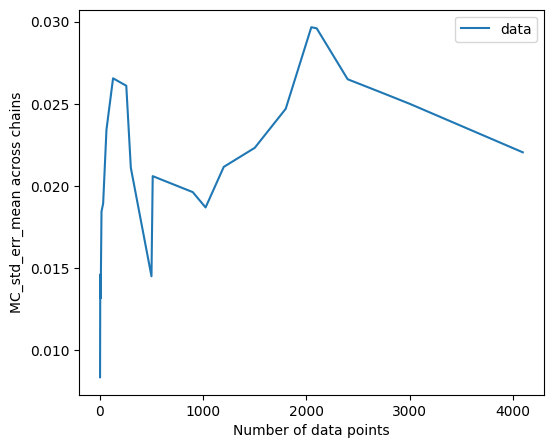

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
sn.lineplot(data = df_normal, x = "n_data", y = "MC_std_err_mean", label="data", ax = ax)
ax.set_xlabel("Number of data points")
ax.set_ylabel("MC_std_err_mean across chains")
#x = np.arange(0, 2**12, 500)
#ax.plot(x, x, label="y=x")
#ax.plot(x, 10*x, label="y=10x")
ax.legend()

In [ ]:
# More check points

n_data = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] #128, 256, 512, 1024, 2048]
dir_names = [f"analysis/train_n_5000kr7_kg3_s1_a1_highlow-nsamples_1200_ndata_{n}_ncheckpoints_{n}/" for n in n_data]
log_files = [f"log-{i}.log" for i in range(1, 21)]

df_checkpoints = get_df(dir_names, log_files, df_keys, file_keys)


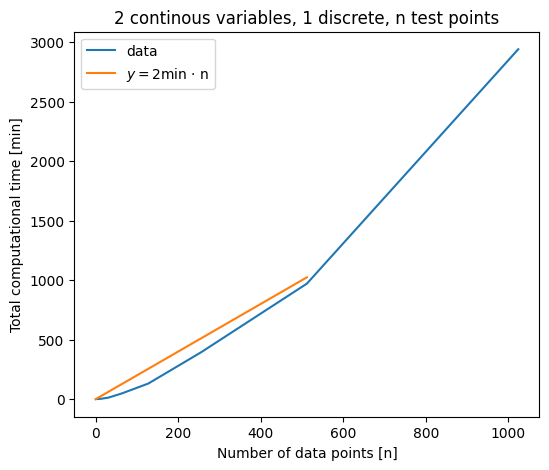

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
df_checkpoints["comp_time_total_mins"] = df_checkpoints["comp_time_total"]/60
sn.lineplot(data = df_checkpoints, x = "n_data", y = "comp_time_total_mins", label="data", ax = ax)
ax.set_xlabel("Number of data points [n]")
ax.set_ylabel("Total computational time [min]")
x = np.linspace(0, 2**9, 500)
#ax.plot(x, x/60, label="y=x")
ax.plot(x, 2*x, label=r"$y=2$min $\cdot$ n")
ax.legend()
ax.set_title("2 continous variables, 1 discrete, n test points")
fig.savefig("comptime.pdf")

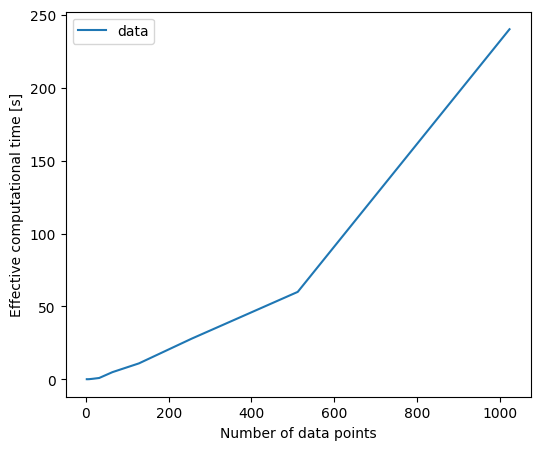

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
df_checkpoints["time/chain_max_mins"] = df_checkpoints["time/chain_max"]/60
sn.lineplot(data = df_checkpoints, x = "n_data", y = "time/chain_max_mins", label="data", ax = ax)
ax.set_xlabel("Number of data points")
ax.set_ylabel("Effective computational time [s]")
x = np.linspace(0, 2**12, 500)
#ax.plot(x, (3/4)*(1/20)*x, label=r"$y=\frac{3}{80}$x")
ax.legend()

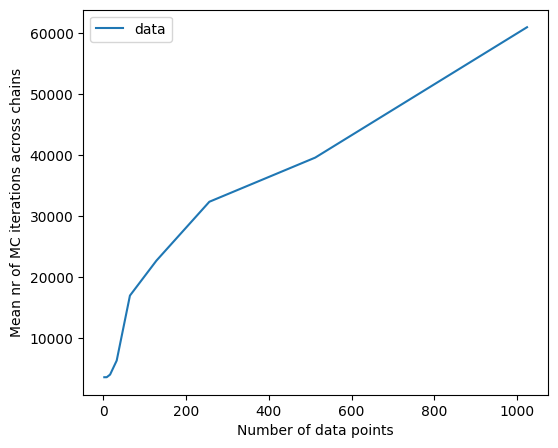

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
sn.lineplot(data = df_checkpoints, x = "n_data", y = "MC_it_mean", label="data", ax = ax)
ax.set_xlabel("Number of data points")
ax.set_ylabel("Mean nr of MC iterations across chains")
x = np.linspace(0, 2**12, 500)
#ax.plot(x, x, label="y=x")
#ax.plot(x, 10*x, label="y=10x")
ax.legend()

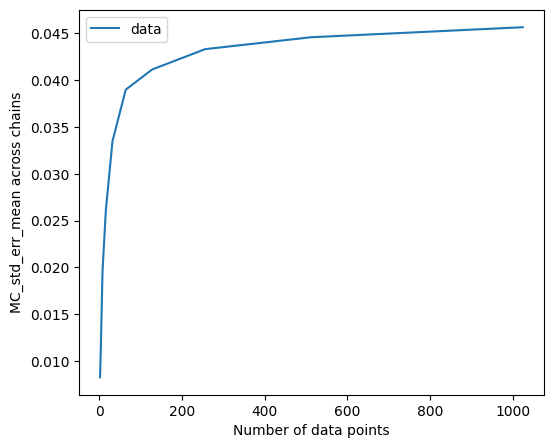

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
sn.lineplot(data = df_checkpoints, x = "n_data", y = "MC_std_err_mean", label="data", ax = ax)
ax.set_xlabel("Number of data points")
ax.set_ylabel("MC_std_err_mean across chains")

ax.legend()

In [ ]:
# Adding two more real variables

n_data = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
#dir_names = [f"analysis/train_n_5000kr7_kg3_s1_a1_highlow-nsamples_1200_ndata_{n}/" for n in n_data]
dir_names = [f"analysis/train_n_5000kr7_kg3_s1_a1_highlow-nsamples_1200_vars-c_x1_x2_a1_a2-ndata_{n}/" for n in n_data]
log_files = [f"log-{i}.log" for i in range(1, 21)]
df_angles = get_df(dir_names, log_files, df_keys, file_keys)


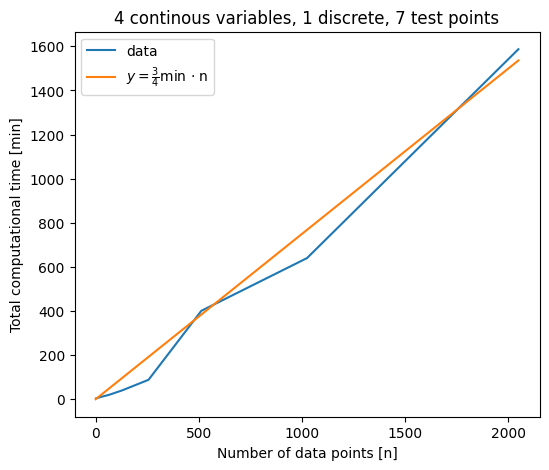

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
df_angles["comp_time_total_mins"] = df_angles["comp_time_total"]/60
sn.lineplot(data = df_angles, x = "n_data", y = "comp_time_total_mins", label="data", ax = ax)
ax.set_xlabel("Number of data points [n]")
ax.set_ylabel("Total computational time [min]")
x = np.linspace(0, 2**11, 500)
#ax.plot(x, x/60, label="y=x")
ax.plot(x, (3/4)*x, label=r"$y=\frac{3}{4} $min $\cdot$ n")
ax.legend()
ax.set_title("4 continous variables, 1 discrete, 7 test points")
fig.savefig("comptime.pdf")